# Virtual Library Enumerated from Building Blocks and Diversity Analyses

### Construct a library of distinct synthesizable compounds through Rdkit's rdChemReactions.EnumerateLibrary.  Internal diversity scores analyses are  performed to calculated and a diverse subset is extracted to cover the approximately same chemical space of the original virtual library.  

### Modeling processes:

#### 1. From the Molport catalog, download two sets of 100 building blocks for acyl chlorides and aldehydes, respectively
#### 2. Define the SMARTs reaction transforms for two chemical reactions of the compound ML218 as show below in scheme 1
#### 3. Using the reactions and building blocks, calculate all the possible products using up to 2 synthetical steps.
#### 4. Plot the Molecular Weight and LogP distributions for the original building blocks,single-step products, and all the possible products.
#### 5. Using the Internal diversity metric and tannimoto distance to calculate the chemical diversity in each of these subsets

## Scheme 1: Two consecutive synthetic reactions to form a new tertiary amine from a primary or secondary amine,  acyl chloride and aldehyde:

#### 1. Boc-protected amines(primary/secondary amines or ammonia) + acyl cholrides building blocks --> N-substitute amides
#### 2. reductive amination: secondary amines + aldehyde or ketone --> imine or iminium --> reduced to a new tertiary amine 

![title](./ml218fu3.jpg)

In [1]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, DataStructs
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.DataManip.Metric import rdMetricMatrixCalc as rdmmc
from rdkit.Chem.Draw import IPythonConsole

import numpy as np

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

### 1. Loading of Molport's Acyl Chlorides and Aldehydes Building Blocks

In [2]:
# load in the MolPort AcylChloride building blocks from the same folder
# create a dictionary to hold MolPort ids and SMILES of AcylChloride building blocks

suppl_acylchloride = Chem.SDMolSupplier('./AcylChloride_MolPort.sdf')
AcylChlorides = {mol.GetProp('MolPort ID'):Chem.MolToSmiles(mol) for mol in suppl_acylchloride}
print(str(len(AcylChlorides))+'\n')
print(dict(itertools.islice(AcylChlorides.items(), 10)))

print('\n')

# load in the MolPort Aldehyde building blocks from the same folder
# create a dictionary to hold MolPort ids and SMILES of Aldehyde building blocks
suppl_aldehyde = Chem.SDMolSupplier('./Aldehyde_MolPort.sdf')
Aldehydes = {mol.GetProp('MolPort ID'):Chem.MolToSmiles(mol) for mol in suppl_aldehyde}


#Aldehydes = {}
#for mol in suppl_aldehyde:    
#    if mol is None: continue
#    print(mol.GetProp('MolPort ID'), Chem.MolToSmiles(mol))
#    Aldehydes[mol.GetProp('MolPort ID')] = Chem.MolToSmiles(mol)

# checking the created Aldehyde dictionary
print(str(len(Aldehydes))+'\n')
print(dict(itertools.islice(Aldehydes.items(), 10)))

100

{'MolPort-029-939-302': 'C#CCCC(=O)Cl', 'MolPort-013-118-009': 'O=C(Cl)CC1CC1', 'MolPort-044-418-908': 'CN(C)CC(=O)Cl', 'MolPort-042-675-645': 'O=C(Cl)c1cc[nH]n1', 'MolPort-029-703-038': 'CC1(C(=O)Cl)CCC1', 'MolPort-009-013-740': 'O=C(Cl)[C@H]1CCOC1', 'MolPort-020-783-061': 'CC(C)[C@H](C)C(=O)Cl', 'MolPort-038-948-446': 'CN(C)CCC(=O)Cl', 'MolPort-035-869-956': 'CCOCCC(=O)Cl', 'MolPort-031-620-908': 'CC(C)OCC(=O)Cl'}


100

{'MolPort-013-899-206': 'O=CCCc1ccc(OC(F)(F)F)cc1', 'MolPort-021-277-876': 'O=CCCCc1ccc(Cl)c(Cl)c1', 'MolPort-021-277-943': 'O=CCCCc1cccc(C(F)(F)F)c1', 'MolPort-020-746-188': 'O=CCc1ccc(OC(F)(F)F)cc1', 'MolPort-013-456-423': 'O=CCc1cccc(OC(F)(F)F)c1', 'MolPort-009-681-113': 'O=CCCc1c(Cl)cccc1Cl', 'MolPort-013-899-205': 'O=CCCc1ccc(Cl)c(Cl)c1', 'MolPort-006-396-268': 'O=CCCc1cccc(C(F)(F)F)c1', 'MolPort-009-677-275': 'O=CCCc1ccc(C(F)(F)F)cc1', 'MolPort-009-681-096': 'O=CCCc1ccccc1C(F)(F)F'}


### 2.1. Specify the Mol Oject for The Starting Material, Boc-Protected Amine

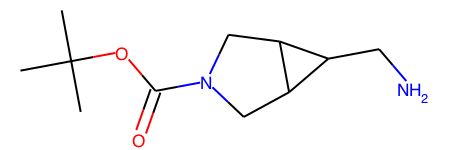

In [3]:
# Initial amine starting material with the t-butyl carbamate protecting group, MolPort-022-442-643
amine_reactant = Chem.MolFromSmiles('CC(C)(C)OC(=O)N1CC2C(C1)C2CN')  
amine_reactant 

### 2.2. SMARTs Reaction Transform for The 1st Reaction, The Acylation of Amine (from 15 to 16 in Scheme 1)

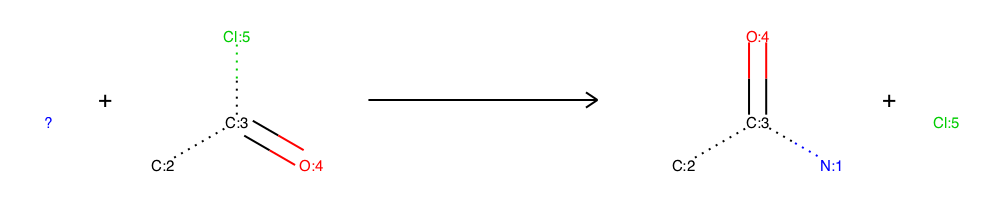

In [4]:
# first reaction:  Boc-protected primary, secondary amine or ammonia + acyl chlorides -> N-substituted amides
rxn1 = AllChem.ReactionFromSmarts('[NX3;H2,H1:1].[#6:2][C:3](=[O:4])[Cl:5]>>[#6:2][C:3](=[O:4])[N:1].[Cl:5]')
Draw.ReactionToImage(rxn1)

### 2.3. SMARTs Reaction Transform for The 2nd Reaction, The Formation of Iminium and Reductive Amination

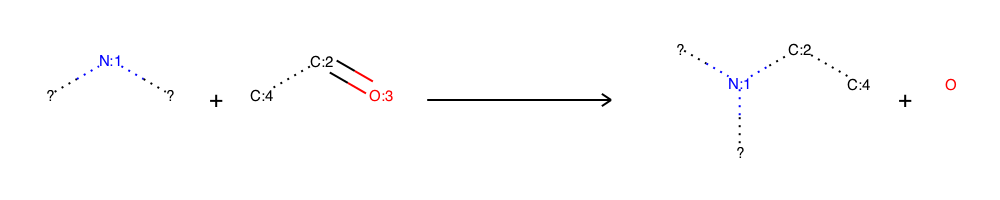

In [5]:
# secondary reactioon:  after deprotection, secondary amines react with aldehydes or ketones to form iminium
# and then go through standard reductive animation to form new tertiary amines  
rxn2 = AllChem.ReactionFromSmarts('[C;!$(C=*):5][N;H1:1]([C;!$(C=*):6]).[C;H1:2](=[O:3])[C:4]>>[C;!$(C=*):5][N;H0:1]([C;!$(C=*):6])[C;H1:2][C:4].[O]')
Draw.ReactionToImage(rxn2)

### 3.1 Synthetical Products of 1st acylation step using the starting amine and acyl chloride building blocks 

### 3.1.1. Testing of Singleton Product from The 1st Reaction

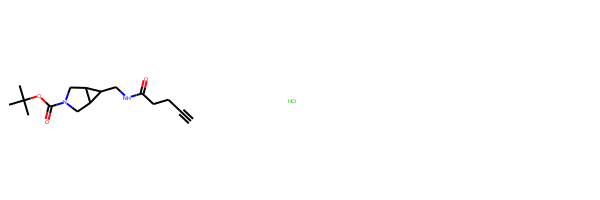

In [6]:
# RunReactants input is a tuple and the out is the tuple of tuple
# the outter tuple - products from different possible reaction routes or sites
# inner tuple - all possible products from the same reaction routes

# singleton test 
ps = rxn1.RunReactants((amine_reactant, Chem.MolFromSmiles('C#CCCC(=O)Cl')))
Chem.MolToSmiles(ps[0][0])
Draw.MolsToGridImage(ps[0])
# 'C#CCCC(=O)NCC1C2CN(C(=O)OC(C)(C)C)CC12'

### 3.1.2. Output All Possible Products from The 1st Reaction

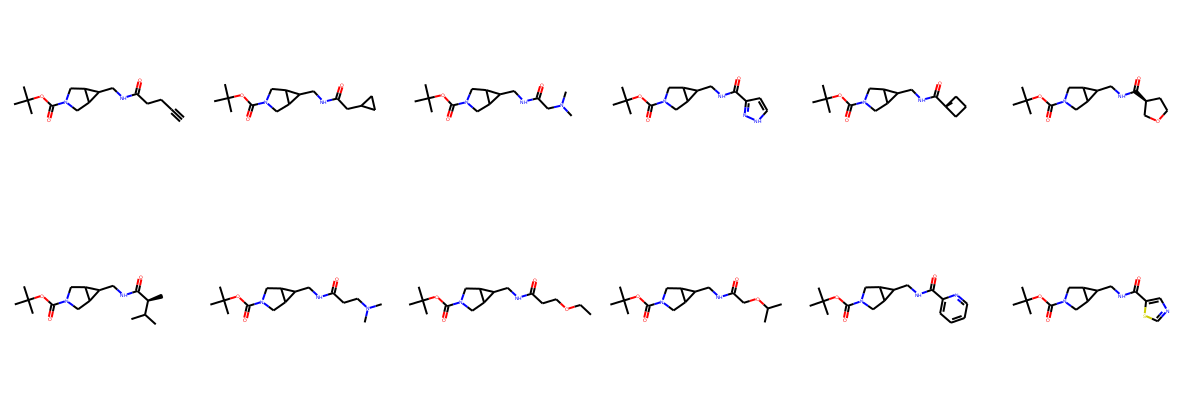

In [7]:
prods_1st_step =[]

for key, value in AcylChlorides.items():
    #print(value)
    ps = rxn1.RunReactants((amine_reactant, Chem.MolFromSmiles(value)))
    if (len(ps)) > 1:
        print(value)
    #print(type(ps[0][0]))
    prods_1st_step.append(Chem.MolFromSmiles(Chem.MolToSmiles(ps[0][0])) )

# check products from 1st reaction step
Draw.MolsToGridImage(prods_1st_step[0:12], molsPerRow=6, maxMols =100)

### 3.2.1.  Deprotection Before The 2nd Step (Removing Boc-Group from Intermediate products of The 1st Reaction) 

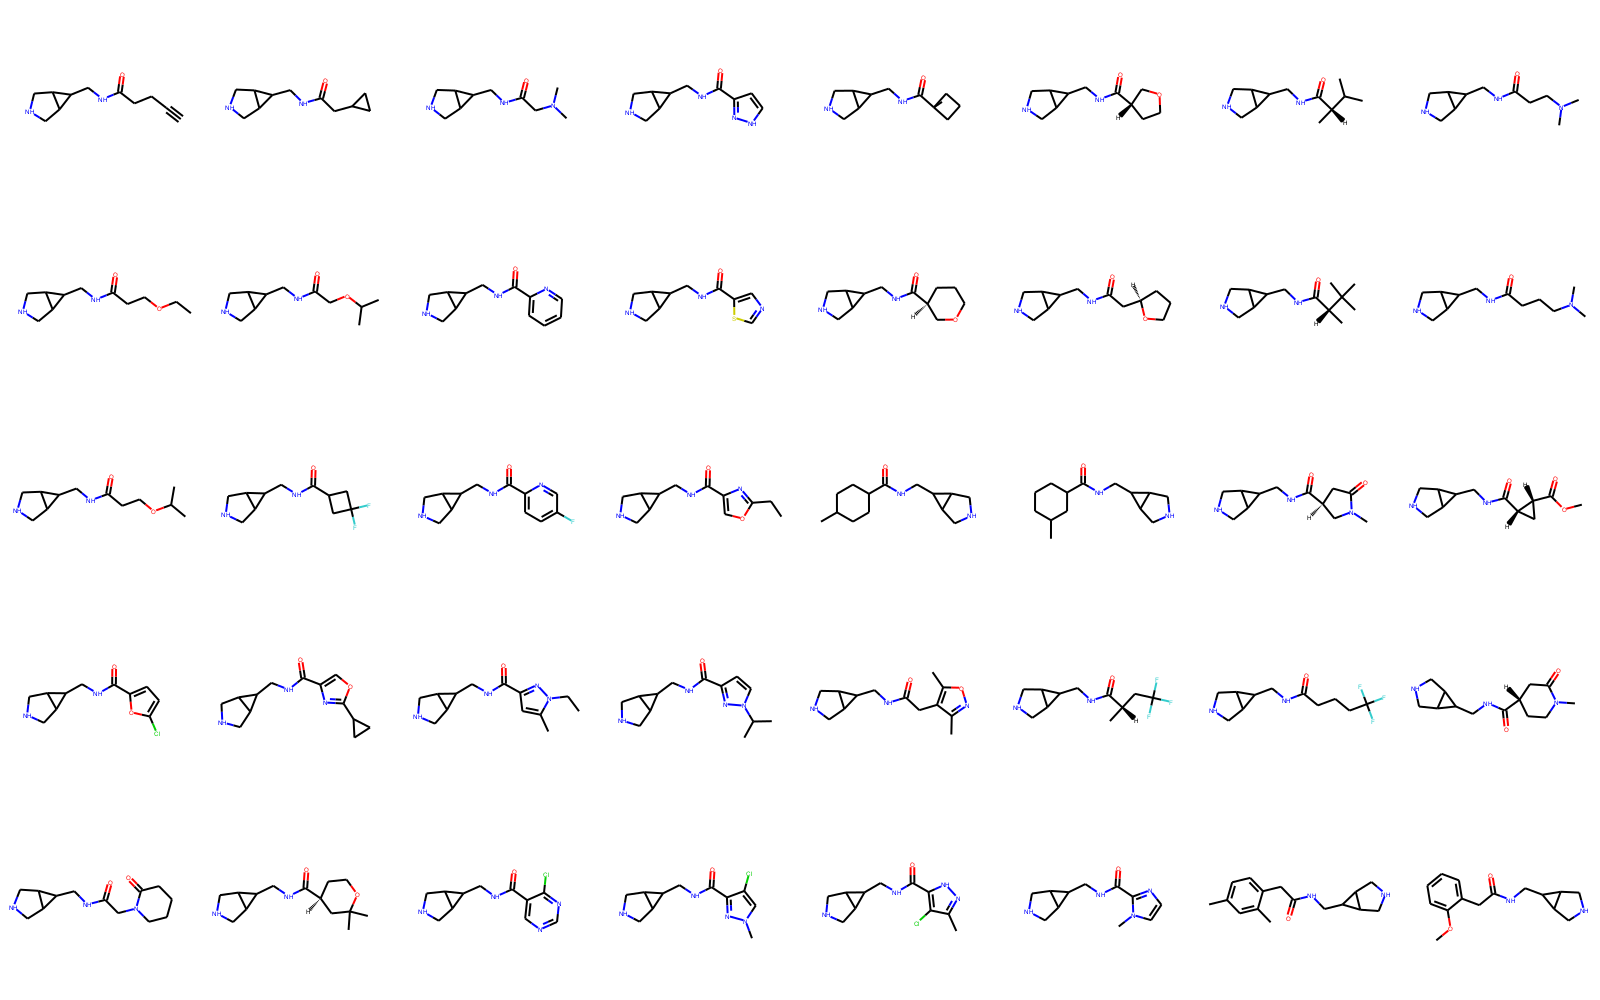

In [8]:
# SMILEs of Boc protection group 
Tbutyloxycarbonyl = 'C(=O)OC(C)(C)C'

# singleton checking before applying on the whole intermediate product list
# start_mol = Chem.MolFromSmiles('CC(C)(C)OC(=O)N1CC2C(CNC(=O)c3cc[nH]n3)C2C1')
# Chem.DeleteSubstructs(start_mol,Chem.MolFromSmiles(Tbutyloxycarbonyl))

# intermediate_products after the Boc deprotection
intermediate_products = [Chem.DeleteSubstructs(mol,Chem.MolFromSmiles(Tbutyloxycarbonyl)) for mol in prods_1st_step]
Draw.MolsToGridImage(intermediate_products[0:40], molsPerRow=8, maxMols =100)

### 3.2.2. Testing of Singleton Product from The 2nd Reaction

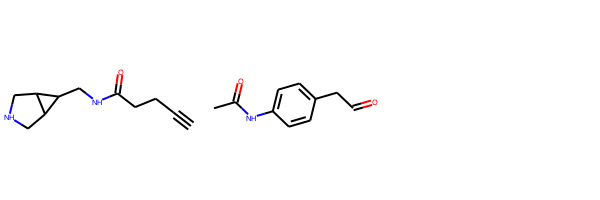

In [9]:
# singleton test whether we get the right product or not from the 2nd defined reaction
ps = rxn2.RunReactants((intermediate_products[0], Chem.MolFromSmiles('O=CCCc1ccc(OC(F)(F)F)cc1')))
Draw.MolsToGridImage([intermediate_products[0],Chem.MolFromSmiles('CC(=O)Nc1ccc(CC=O)cc1')])

### 3.2.3. Output the Final Virtual Library of Tertiary Amine Products (100 * 100 Compounds) from the 2nd Reaction using the EnumerateLibraryFromReaction Generator

number of compounds in the constructed virtual library:
10000


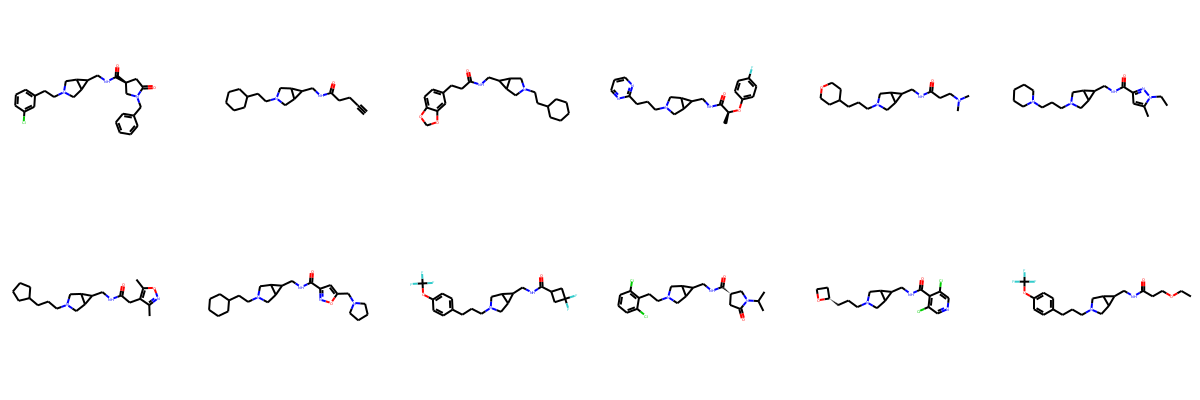

In [10]:
# reactant sidechain set s1 for the previous intermediate products from the first step, after the Boc deprotection 
s1 = intermediate_products
# reactant sidechain set s2 for aldehydes 
s2 = [mol for mol in suppl_aldehyde]

# Give the 2nd reaction rxn2, returns a generator for the virtual tertiary amine library
# for specified sequence of sidechain sets s1, s2
r = AllChem.EnumerateLibraryFromReaction(rxn2, [s1,s2])

# check the number of final products make sense or not
# since in this particular case, our starting material, Boc-protected amines, is racemic mixture
# we will get 20000 instead of 10000 due to (R,S) configuration
#def count(iter):
#    return sum(1 for _ in iter)
#print(count(r))
#print(list(r))
#Draw.MolToImage( list(r)[0][0])

# remove duplicate mol due to the racemic mixture case and obtain the list of final unduplication mol lists 
final_smiles  =list(set([Chem.MolToSmiles(x[0]) for x in list(r)]))
virt_lib = [Chem.MolFromSmiles(x) for x in final_smiles ]

print('number of compounds in the constructed virtual library:')
print(len(virt_lib))
Draw.MolsToGridImage(virt_lib[0:12] , molsPerRow=6, maxMols =100)


### 3.3. Distribution Plots of MW & LogP for Original Building Blocks, Single-Step Products, & Final Virtual Library

### 3.3.1. Obtain MW & LogP Values from Rdkit 

In [11]:
# MW & logP value list for acyl chloride building blocks
MW_acylchlorides   = [Descriptors.ExactMolWt(mol) for mol in suppl_acylchloride]
LOGP_acylchlorides = [Descriptors.MolLogP(mol) for mol in suppl_acylchloride]

# MW & logP value list for aldehyde building blocks
MW_aldehydes   = [Descriptors.ExactMolWt(mol) for mol in suppl_aldehyde ]
LOGP_aldehydes = [Descriptors.MolLogP(mol) for mol in suppl_aldehyde ]


# MW & logP value list for the intermediate product from the first reaction (after Boc deprotection)
MW_interprods    = [Descriptors.ExactMolWt(mol) for mol in intermediate_products ]
LOGP_interprods = [ Descriptors.MolLogP(mol) for mol in intermediate_products ]

# MW & logP value list for final virtual library compounds
MW_virtlib   = [Descriptors.ExactMolWt(mol) for mol in virt_lib]
LOGP_virtlib = [Descriptors.MolLogP(mol) for mol in virt_lib]

### 3.3.2. Distribution Plots/Density Curve of MW & LOGP for Exploring Data
the statistics on small dataset (e.g. building block sets with only 100 compounds) may not be meaningful 

/Users/jinbo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


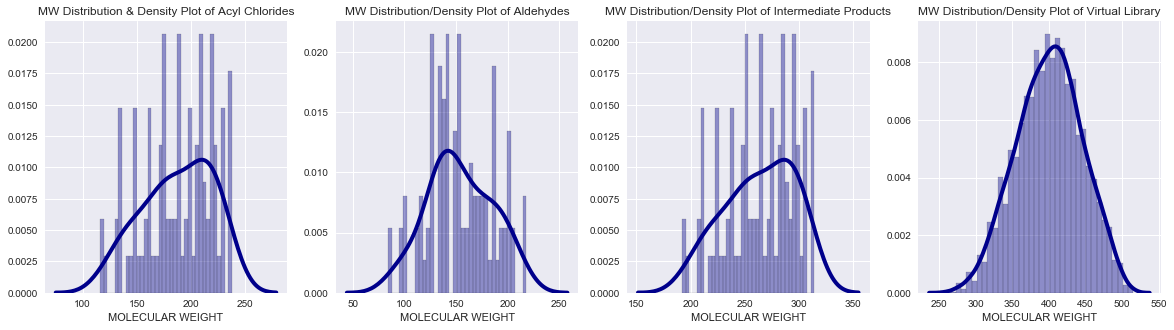

In [12]:
# Histogram and Density Plots of MW 
sns.set(rc={'figure.figsize':(20,5)})

plt.subplot(141)
sns.distplot(MW_acylchlorides , hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('MW Distribution & Density Plot of Acyl Chlorides')
plt.xlabel('MOLECULAR WEIGHT')

plt.subplot(142)
sns.distplot(MW_aldehydes, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('MW Distribution/Density Plot of Aldehydes')
plt.xlabel('MOLECULAR WEIGHT')

plt.subplot(143)
sns.distplot(MW_interprods, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('MW Distribution/Density Plot of Intermediate Products')
plt.xlabel('MOLECULAR WEIGHT')

plt.subplot(144)
sns.distplot(MW_virtlib, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('MW Distribution/Density Plot of Virtual Library')
plt.xlabel('MOLECULAR WEIGHT')

plt.show()

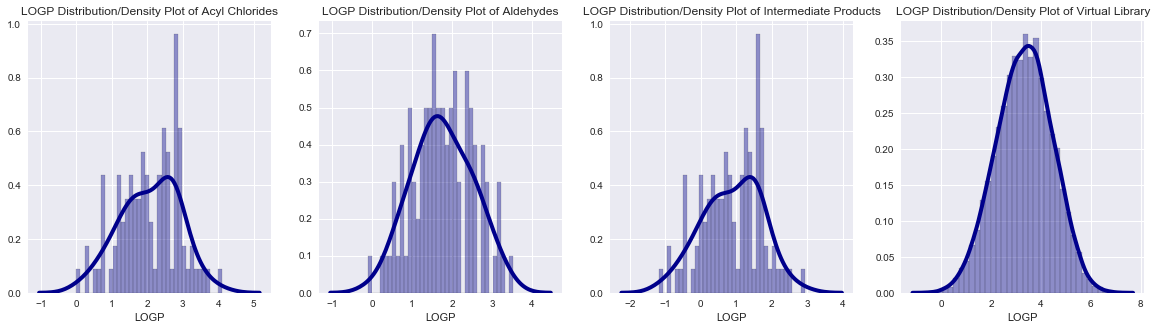

In [13]:
# Histogram and Density Plots of MW 
sns.set(rc={'figure.figsize':(20,5)})

plt.subplot(141)
sns.distplot(LOGP_acylchlorides , hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('LOGP Distribution/Density Plot of Acyl Chlorides')
plt.xlabel('LOGP')

plt.subplot(142)
sns.distplot(LOGP_aldehydes, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('LOGP Distribution/Density Plot of Aldehydes')
plt.xlabel('LOGP')

plt.subplot(143)
sns.distplot(LOGP_interprods, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('LOGP Distribution/Density Plot of Intermediate Products')
plt.xlabel('LOGP')

plt.subplot(144)
sns.distplot(LOGP_virtlib, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('LOGP Distribution/Density Plot of Virtual Library')
plt.xlabel('LOGP')

plt.show()

### 5. Chemical Diversity in Each of These Subsets Based on Internal Diversity Metric & Tanimoto Distance

### Here we adopt the Internal Diversity Score mentioned in Mostapha Benhenda's Paper  ["ChemGAN challenge for drug discovery: can AI reproduce natural chemical diversity?"](https://arxiv.org/abs/1708.08227)   In Mostapha's paper, for a set of molecules A of size |A|, the internal diversity index I(A) is calcuated based by the average of the Tanimoto-distance Td of molecules of A with respect to each other:

\begin{equation*}
I(A) = \frac{1}{\mid A\mid^2}  \sum\limits_{(x,y)\in A\times A} {T_{d}(x,y)}
\end{equation*}

### 5.1.  Tanimoto Distance Matrix from 1024-bits Mongan Fingerprint

In [14]:
###########################################################
# Tanimoto Distance Matrix of Acyl Chloride Building Blocks
###########################################################
# Return the explicitBitVect of Morgan fingerprint list for Acyl Chloride Building Blocks
fps_acylchlorides = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in suppl_acylchloride]

# the size of fingerprint for Acyl Chloride Building Blocks
nfps_acylchlorides = len(fps_acylchlorides)

# Distance matrix from the BitVects list using the Tanimoto distance metric of Acyl Chloride Building Blocks
sMat_acylchlorides = rdmmc.GetTanimotoDistMat(fps_acylchlorides)

###########################################################
# Tanimoto Distance Matrix of Aldehyde Building Blocks
###########################################################
# Return the explicitBitVect of Morgan fingerprint list for Acyl Chloride Building Blocks
fps_aldehydes = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in suppl_aldehyde]

# the size of fingerprint for Aldehyde Building Blocks
nfps_aldehydes = len(fps_aldehydes)

# Distance matrix from the BitVects list using the Tanimoto distance metric of Aldehyde Building Blocks
sMat_aldehydes = rdmmc.GetTanimotoDistMat(fps_aldehydes)

#############################################
# Tanimoto Distance Matrix of Virtual Library
#############################################
# Return the explicitBitVect of Morgan fingerprint list for the constructed virtual library set 
fps_VL = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in virt_lib]

# the size of fingerprint
nfps_VL = len(fps_VL)

# Distance matrix from the BitVects list using the Tanimoto distance metric
sMat_VL = rdmmc.GetTanimotoDistMat(fps_VL)

### 5.2. Calculate Internal Diversity Score in each of these subsets

In [15]:
# Calculate Internal Diversity Score for the given one-dimentional ndarray 
# from the lower triangle elements of the symmetric tannimoto distance matrix
# as well as the size of original fingeprint list 
def internal_diversity_score(A, n):
    return round(np.sum(A)/n/n,3)

# Return the Internal Diversity Score for the Acyl Chloride Building Block compound set
print("Internal Diversity Score for the Acyl Chloride Building Block compound set is:\n")
print(internal_diversity_score(sMat_acylchlorides, nfps_acylchlorides))
print('\n')

# Return the Internal Diversity Score for the Aldehyde Building Block compound set
print("Internal Diversity Score for the Aldehyde Building Block compound set is:\n")
print(internal_diversity_score(sMat_aldehydes, nfps_aldehydes))
print('\n')

# Return the Internal Diversity Score for the final virtual library compound set
print("Internal Diversity Score for the final virtual library compound set is:\n")
print(internal_diversity_score(sMat_VL, nfps_VL))
print('\n')

Internal Diversity Score for the Acyl Chloride Building Block compound set is:

0.392


Internal Diversity Score for the Aldehyde Building Block compound set is:

0.375


Internal Diversity Score for the final virtual library compound set is:

0.316




### 5.3. Select Diverse Subset from the Original Virtual Library using  MinMax algorithms

In [17]:
# Identify 100 diverse molecules from the original virtual library
def distij(i,j,fps=fps_VL):
    return 1-DataStructs.TanimotoSimilarity(fps[i],fps[j])

picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps_VL,100,seed=23)
#list(pickIndices)
picks = [virt_lib[x] for x in pickIndices]

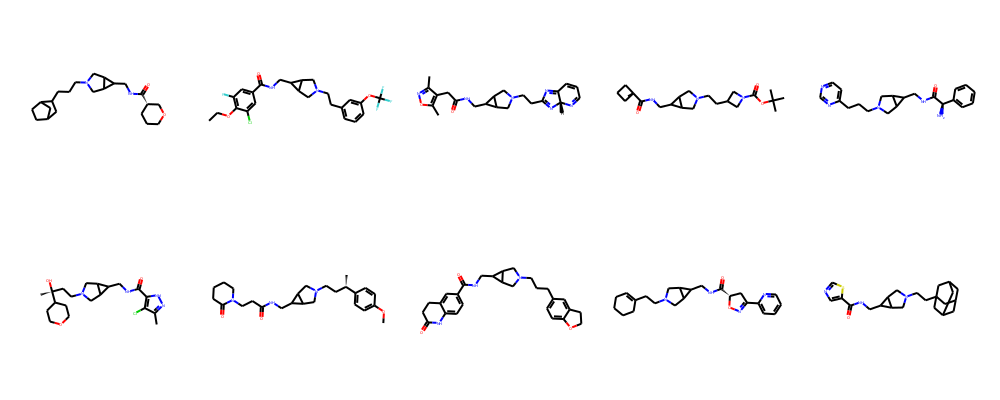

In [18]:
Draw.MolsToGridImage(picks[0:10] , molsPerRow=5, maxMols =200)